In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных
data = pd.read_csv('heart.csv')

data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
# Информация о данных
print(data.info())

# Проверка на пропущенные значения
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak          

In [ ]:
data = pd.get_dummies(data, columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], drop_first=True)

In [ ]:
# Список числовых признаков
numeric_vars = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data[numeric_vars] = scaler.fit_transform(data[numeric_vars])

In [ ]:
# Целевая переменная
y = data['HeartDisease'].values

# Признаки
X = data.drop('HeartDisease', axis=1).values

# Нормализация признаков
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [ ]:
import numpy as np

class HMC:
    def __init__(self, U, grad_U, epsilon, L, current_q):
        self.U = U
        self.grad_U = grad_U
        self.epsilon = epsilon
        self.L = L
        self.current_q = current_q

    def sample(self):
        q = np.copy(self.current_q)
        p = np.random.randn(len(q))  # Генерируем импульсы

        current_p = np.copy(p)

        # Симуляция методом leapfrog
        p -= 0.5 * self.epsilon * self.grad_U(q)
        for _ in range(self.L):
            q += self.epsilon * p
            if _ != self.L - 1:
                p -= self.epsilon * self.grad_U(q)
        p -= 0.5 * self.epsilon * self.grad_U(q)
        p = -p  # Отражаем импульс для симметрии

        # Вычисляем Гамильтониан
        current_U = self.U(self.current_q)
        current_K = np.sum(current_p ** 2) / 2
        proposed_U = self.U(q)
        proposed_K = np.sum(p ** 2) / 2

        # Решаем, принять ли новое состояние
        acceptance_prob = np.exp(current_U - proposed_U + current_K - proposed_K)
        if np.random.rand() < acceptance_prob:
            self.current_q = q  # Принимаем предложение

        return self.current_q


In [ ]:
def U(theta):
    z = X @ theta
    log_likelihood = y * z - np.log(1 + np.exp(z))
    prior = -0.5 * np.sum(theta ** 2)
    return - (np.sum(log_likelihood) + prior)

def grad_U(theta):
    z = X @ theta
    y_pred = 1 / (1 + np.exp(-z))
    gradient = X.T @ (y - y_pred) - theta
    return -gradient


In [ ]:
epsilon = 0.005
L = 50
num_samples = 2000

# Инициализация параметров
np.random.seed(42)
initial_theta = np.zeros(X.shape[1])

hmc = HMC(U=U, grad_U=grad_U, epsilon=epsilon, L=L, current_q=initial_theta)

samples = []
for i in range(num_samples):
    sample = hmc.sample()
    samples.append(sample)
    if (i + 1) % 500 == 0:
        print(f'Итерация {i + 1}/{num_samples}')


Итерация 500/2000
Итерация 1000/2000
Итерация 1500/2000
Итерация 2000/2000


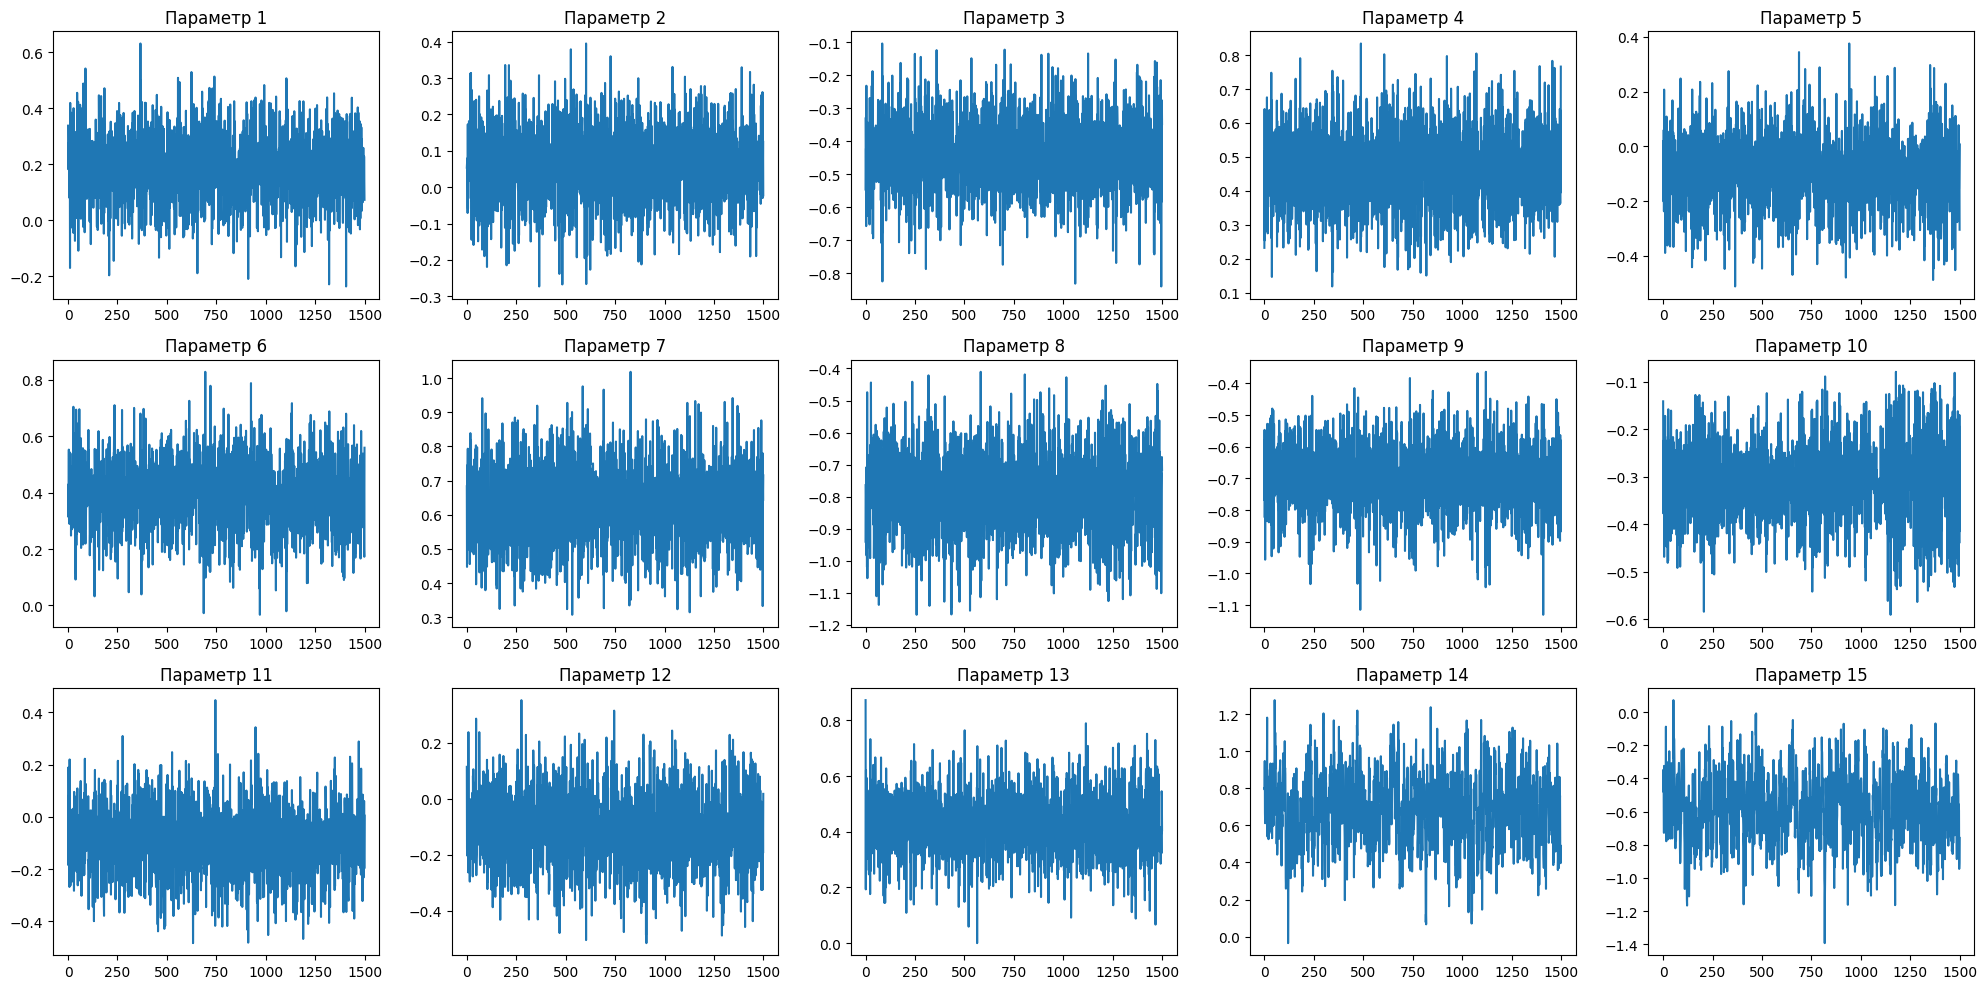

In [ ]:
samples = np.array(samples)
burn_in = 500  # Отбросим первые 500 выборок
samples_post_burn_in = samples[burn_in:]

# Построим траектории параметров
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 5, figsize=(20, 10))
axs = axs.ravel()
for i in range(samples.shape[1]):
    axs[i].plot(samples_post_burn_in[:, i])
    axs[i].set_title(f'Параметр {i+1}')
plt.tight_layout()
plt.show()


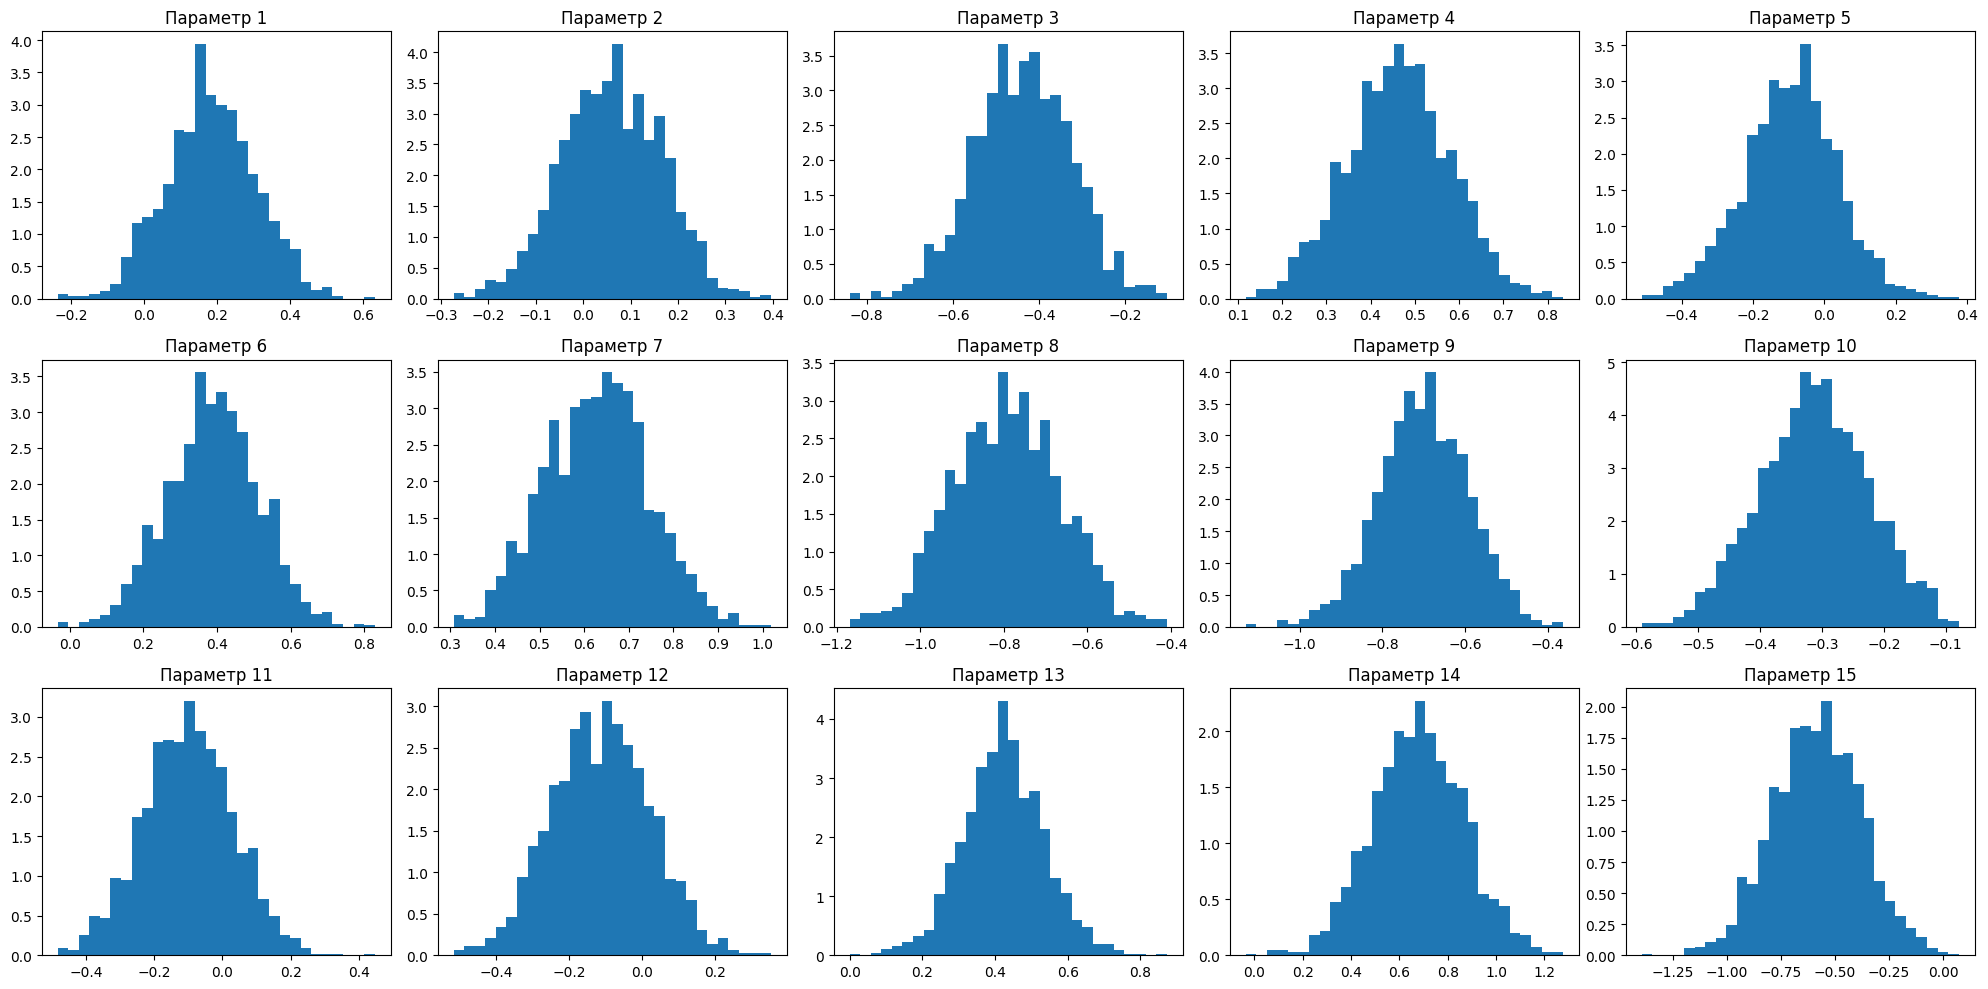

In [ ]:
fig, axs = plt.subplots(3, 5, figsize=(20, 10))
axs = axs.ravel()
for i in range(samples.shape[1]):
    axs[i].hist(samples_post_burn_in[:, i], bins=30, density=True)
    axs[i].set_title(f'Параметр {i+1}')
plt.tight_layout()
plt.show()



In [ ]:
theta_mean = np.mean(samples_post_burn_in, axis=0)
theta_std = np.std(samples_post_burn_in, axis=0)

for i in range(len(theta_mean)):
    print(f'Параметр {i+1}: среднее = {theta_mean[i]:.4f}, стандартное отклонение = {theta_std[i]:.4f}')


Параметр 1: среднее = 0.1834, стандартное отклонение = 0.1232
Параметр 2: среднее = 0.0593, стандартное отклонение = 0.1053
Параметр 3: среднее = -0.4383, стандартное отклонение = 0.1133
Параметр 4: среднее = 0.4636, стандартное отклонение = 0.1167
Параметр 5: среднее = -0.0947, стандартное отклонение = 0.1315
Параметр 6: среднее = 0.3894, стандартное отклонение = 0.1243
Параметр 7: среднее = 0.6289, стандартное отклонение = 0.1160
Параметр 8: среднее = -0.7933, стандартное отклонение = 0.1296
Параметр 9: среднее = -0.7008, стандартное отклонение = 0.1097
Параметр 10: среднее = -0.3123, стандартное отклонение = 0.0879
Параметр 11: среднее = -0.1005, стандартное отклонение = 0.1319
Параметр 12: среднее = -0.1124, стандартное отклонение = 0.1347
Параметр 13: среднее = 0.4233, стандартное отклонение = 0.1110
Параметр 14: среднее = 0.6787, стандартное отклонение = 0.1903
Параметр 15: среднее = -0.5827, стандартное отклонение = 0.2029


In [ ]:
# Вероятности наличия заболевания
z = X @ theta_mean
y_pred_prob = 1 / (1 + np.exp(-z))

# Преобразование вероятностей в классы
y_pred_class = (y_pred_prob >= 0.5).astype(int)

# Оценка точности
accuracy = np.mean(y_pred_class == y)
print(f'Точность модели: {accuracy * 100:.2f}%')


Точность модели: 86.38%


In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y, y_pred_class)
print('Матрица ошибок:')
print(conf_matrix)


Матрица ошибок:
[[350  60]
 [ 65 443]]


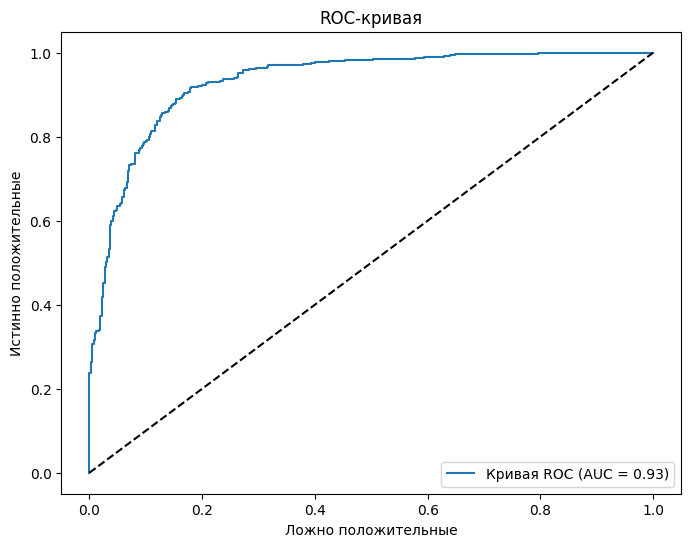

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Кривая ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Ложно положительные')
plt.ylabel('Истинно положительные')
plt.title('ROC-кривая')
plt.legend(loc='lower right')
plt.show()
